In [1]:
import numpy as np
import xarray as xr
import xrft
import matplotlib.pyplot as plt

## Solve system:

$ \huge f(t) = t_0 + \sum (C_n \cos(\omega t_i) + S_n \sin(\omega t_i)) $

1.1469251135295397 3.5128828066464437


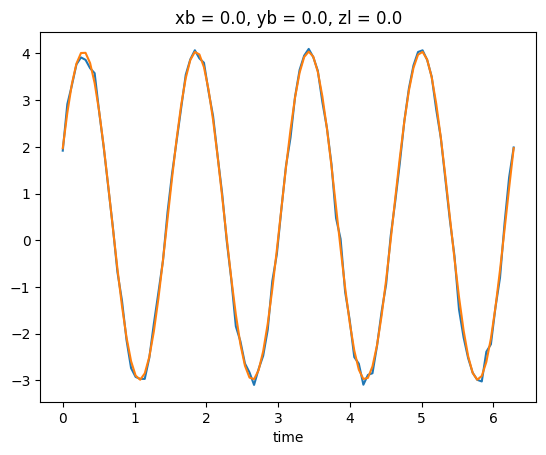

In [56]:
t = np.zeros(100) + 0.5 + 0.1 * np.random.randn(100)
AngFreq = 4
phases = [0,0.45,0.9,1.54,5.43]

for phase in phases:
    # plt.plot(t)
    t += np.sin(AngFreq * np.linspace(0,2 * np.pi,100) + phase)


# Reshape the 1D array to (100, 1, 1)
reshaped_t = np.reshape(t, (100, 1, 1,1))

# Repeat the values along the second and third axes
t = np.tile(reshaped_t, (1, 10, 10,10))


data = xr.DataArray(t, dims=['time',"xb","yb","zl"], 
                    coords={
                        'time': np.linspace(0,2*np.pi,100),
                        "xb":np.linspace(0,1,10),
                        "yb":np.linspace(0,1,10),
                        "zl":np.linspace(0,1,10)}) 

def harmonic_analysis(data):
    data = data.transpose("time","xb","yb","zl")
    coeff_matrix = np.zeros((len(data.time), 3))
    coeff_matrix[:,0] = 1
    coeff_matrix[:,1] = np.cos(AngFreq * data.time)
    coeff_matrix[:,2] = np.sin(AngFreq * data.time)
    coeff_matrix

    def ls(timeseries):
        t0,C,S = np.linalg.lstsq(coeff_matrix, timeseries, rcond=None)[0]
        phase = np.arctan2(S,C)
        amp = np.sqrt(C**2 + S**2)
        return amp,phase
    out = xr.DataArray(
        np.apply_along_axis(ls,0,data),
        dims = ["amp+phase","xb","yb","zl"],
        coords = {"amp+phase": ["amp","phase"],"xb":data.xb,"yb":data.yb,"zl":data.zl}
    )
    
    
    return out

data[:,0,0,0].plot()
plt.plot(data.time,t0 + C * np.cos(AngFreq * data.time) + S * np.sin(AngFreq * data.time))
phase = np.arctan2(S,C)
amp = np.sqrt(C**2 + S**2)
print(phase,amp)

In [1]:
from eofs.standard import Eof

def eof_decomp_propagIT(data):

    '''

    decomposes input data into horizontal EOFs and vertical PCs till a specific depth and calculates variance fractions

    uses package: eofs.standard

    

    returns:

    xarray of EOFs (1 to 10), xarray of PCs (1 to 10) and variance fractions

    

    make sure data has dim depth and not lev!

    '''

    # level-index till which we perform the EOF-analysis

    crop = 70

    # data 

    data_cropped = data.isel(depth=slice(0,crop))

    print('data cropped till levidx',crop)

    # EOF and PC solver

    solver = Eof(data_cropped.values)

    E = solver.eofs(eofscaling=2, neofs=10) # scaling=2 EOFs are multiplied by the square-root of their eigenvalues

    P = solver.pcs(pcscaling=1, npcs=10) # scaling=1 PCs are divided by the square-root of their eigenvalues

    #depths_crop = depths.isel(depth=slice(0,crop))

    print('EOFs and PCs calculated. EOFs shape:',E.shape)

    # variance_fractions

    v = solver.varianceFraction(neigs=10)

    print('variance fractions calculated')

    # convert E and P to xarrays

    E = xr.DataArray(E,dims = ('eofs','yb','xb','var','time'),coords = {'eofs':['1','2','3','4','5','6','7','8','9','10'],'lat':data.lat,'lon':data.lon,'var':['Acos','Asin'],'time':data.time})

    P = xr.DataArray(P,dims = ('depth','PCs'),coords = {'depth':np.arange(0,crop),'PCs':['1','2','3','4','5','6','7','8','9','10']})

    return E, P, v


# Data prep:

def prepdataforeof(A,phi):

    '''

    amplitude: A(x,y,z) from harmonic analysis

    phase: \phi(x,y,z) from harmonic analysis

    calculates the terms A(x,y,z)cos(\phi(x,y,z)) and A(x,y,z)sin(\phi(x,y,z))

    then concatinates and transposes the result, so it can be used for eof-decomposition

    '''

    Acos = A * np.cos(np.deg2rad(phi))

    Asin = A * np.sin(np.deg2rad(phi))

    

    dataforeof = xr.concat([Acos,Asin],dim='var')

    # Below var might be a coorinate distinguishing the variable?
    dataforeof = dataforeof.transpose('depth','yb','xb','var','time')
    # dataforeof = dataforeof.transpose('zl','yb','xb','time')

    

    return dataforeof


def harmonic_analysis(data,freq = 2*np.pi/(12.42*3600)):
    data = data.transpose("time","xb","yb","zl")
    coeff_matrix = np.zeros((len(data.time), 3))
    coeff_matrix[:,0] = 1
    coeff_matrix[:,1] = np.cos(AngFreq * data.time)
    coeff_matrix[:,2] = np.sin(AngFreq * data.time)
    coeff_matrix

    def ls(timeseries):
        t0,C,S = np.linalg.lstsq(coeff_matrix, timeseries, rcond=None)[0]
        phase = np.arctan2(S,C)
        amp = np.sqrt(C**2 + S**2)
        return amp,phase
    out = np.apply_along_axis(ls,0,data)
    amp = out[0,:,:,:]
    phase = out[1,:,:,:]

    amp = xr.DataArray(
        out[0,:,:,:],
        dims = ["xb","yb","zl"],
        coords = {"xb":data.xb,"yb":data.yb,"zl":data.zl}
    ).rename("amp")
    phase = xr.DataArray(
        out[1,:,:,:],
        dims = ["xb","yb","zl"],
        coords = {"xb":data.xb,"yb":data.yb,"zl":data.zl}
    ).rename("phase")
    
    
    return xr.merge([amp,phase])

<>:64: SyntaxWarning: invalid escape sequence '\p'
<>:64: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_197080/4007353190.py:64: SyntaxWarning: invalid escape sequence '\p'
  '''
/tmp/ipykernel_197080/4007353190.py:64: SyntaxWarning: invalid escape sequence '\p'
  '''


ModuleNotFoundError: No module named 'eofs'